In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
import cv2
from PIL import Image

import torch
from torch.autograd import Variable
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision as tv
import torch.nn.functional as F
from torch import Tensor

In [2]:
class CustomCityScapeDS(Dataset):
    def __init__(self, root = None, split = "train", mode = "fine", 
                 transform = None, sematic_transform = None):
        self.split = split
        self.mode = mode
        self.images = []
        self.targets = []
        self.target_transform = {}

        self.semantic_map = {
            0 : ['unlabeled', 19, 'void'], 
            1 : ['ego vehicle', 19, 'void'],
            2 : ['rectification border', 19, 'void'],
            3 : ['out of roi', 19, 'void'],
            4 : ['static', 19, 'void'],
            5 : ['dynamic', 19, 'void'],
            6 : ['ground', 19, 'void'],
            7 : ['road', 0, 'flat'],
            8 : ['sidewalk', 1, 'flat'],
            9 : ['parking', 19, 'flat'],
            10 : ['rail track', 19, 'flat'],
            11 : ['building', 2, 'construction'],
            12 : ['wall', 3, 'construction'],
            13 : ['fence', 4, 'construction'],
            14 : ['guard rail', 19, 'construction'],
            15 : ['bridge', 19, 'construction'],
            16 : ['tunnel', 19, 'construction'],
            17 : ['pole', 5, 'object'],
            18 : ['polegroup', 19, 'object'],
            19 : ['traffic light', 6, 'object'],
            20 : ['traffic sign', 7, 'object'],
            21 : ['vegetation', 8, 'nature'],
            22 : ['terrain', 9, 'nature'],
            23 : ['sky', 10, 'sky'],
            24 : ['person', 11, 'human'],
            25 : ['rider', 12, 'human'],
            26 : ['car', 13, 'vehicle'],
            27 : ['truck', 14, 'vehicle'],
            28 : ['bus', 15, 'vehicle'],
            29 : ['caravan', 19, 'vehicle'],
            30 : ['trailer', 19, 'vehicle'],
            31 : ['train', 16, 'vehicle'],
            32 : ['motorcycle', 17, 'vehicle'],
            33 : ['bicycle', 18, 'vehicle'],
            34 : ['license plate', -1, 'vehicle']
        }
        
        if transform:
            self.transform = transform
        else:
            self.transform = transforms.Compose([transforms.Resize((256, 512)), transforms.ToTensor()])
        
        if sematic_transform:
            self.target_transform['semantic'] = sematic_transform
        else:
            self.target_transform['semantic'] = transforms.Compose(
                [transforms.Resize((256, 512)), transforms.PILToTensor(), self.make_semantic_class])

        self.root = "/media/mountHDD2/cityscapes" if not root else root

        if self.mode == "fine":
            if self.split not in ['train', 'val', 'test']:
                raise ValueError("self.split has to be one of ['train', 'val', 'test']")
        elif self.mode == "coarse":
            if self.split not in ['train', 'train_extra', 'val']:
                raise ValueError("self.split has to be one of ['train', 'train_extra', 'val']")
        else:
            raise Value_colorError(f"mode cannot be {self.mode}")

        self.img_dir = self.root + f"/leftImg8bit/{self.split}"
        self.mode_folder = "gtFine" if self.mode == "fine" else "gtCoarse"
        self.semantic_dir = self.root + f"/{self.mode_folder}/{self.split}"
        self.depth_dir = self.root + f"/disparity/{self.split}"

        for check_dir in [self.img_dir, self.semantic_dir, self.depth_dir]:
            if not os.path.exists(check_dir):
                print(f"The dataset source is not available or not extracted at {self.root}")

        print("Data Set Setting Up")
        for city in tqdm(os.listdir(self.img_dir)):
            img_dir = os.path.join(self.img_dir, city)
            semantic_target_dir = os.path.join(self.semantic_dir, city)
            depth_target_dir = os.path.join(self.depth_dir, city)
            for file_name in os.listdir(img_dir):
                self.images.append(os.path.join(img_dir, file_name))

                fn = file_name.split("_leftImg8bit")[0]
                mode_folder = semantic_target_dir.split("/")[-3]

                self.targets.append(
                    {
                        "semantic" : os.path.join(semantic_target_dir, f"{fn}_{mode_folder}_labelIds.png"),
                        "depth" : os.path.join(depth_target_dir, f"{fn}_disparity.png"),
                    }
                )
                
        print("Done")
    
    def make_semantic_class(self, x):
        encx = torch.zeros(x.shape, dtype=torch.long)
        for label in self.semantic_map:
            encx[x == label] = self.semantic_map[label][1]
        onehot = F.one_hot(encx.squeeze(1), 20).permute(0, 3, 1, 2)[0].float()
        return onehot[:-1]

    def process_depth(self, x):
        depth = cv2.imread(x, cv2.IMREAD_UNCHANGED).astype(np.float32)
        depth = cv2.resize(depth, (512, 256))
        depth[depth > 0] = (depth[depth > 0] - 1) / 256
        
        # depth = 0.209313 * 2262.52 / depth

        depth[depth == np.inf] = 0
        depth[depth == np.nan] = 0
        depth[depth < 0] = 0

        # depth = np.minimum(depth, 100) 

        torch_depth = torch.from_numpy(depth).unsqueeze(0) / 255.0

        return torch_depth

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.transform(Image.open(self.images[idx]).convert("RGB"))

        target = {}
        target['semantic'] = self.target_transform['semantic'](Image.open(self.targets[idx]['semantic']))
        target['depth'] = self.process_depth(self.targets[idx]['depth'])

        return img, target

In [3]:
train_fine_ds = CustomCityScapeDS(split = 'train', mode = 'fine')
valid_fine_ds = CustomCityScapeDS(split = 'val', mode = 'fine')
test_fine_ds = CustomCityScapeDS(split = 'test', mode = 'fine')

print(len(train_fine_ds))
print(len(valid_fine_ds))
print(len(test_fine_ds))

Data Set Setting Up


100%|██████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 1970.39it/s]


Done
Data Set Setting Up


100%|████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1983.12it/s]


Done
Data Set Setting Up


100%|████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1357.97it/s]

Done
2975
500
1525


In [4]:
train_fine_dl = DataLoader(train_fine_ds, batch_size=32, shuffle=True, pin_memory = True, num_workers=24)
valid_fine_dl = DataLoader(valid_fine_ds, batch_size=32, shuffle=True, pin_memory = True, num_workers=24)
test_fine_dl = DataLoader(test_fine_ds, batch_size=32, shuffle=True, pin_memory = True, num_workers=24)

print("#Training Batch: {}".format(len(train_fine_dl)))
print("#Validation Batch: {}".format(len(valid_fine_dl)))
print("#Testing Batch: {}".format(len(test_fine_dl)))

#Training Batch: 93
#Validation Batch: 16
#Testing Batch: 48


data shape: torch.Size([3, 256, 512])
semantic_target shape: torch.Size([19, 256, 512])
depth_target shape: torch.Size([1, 256, 512])
Number classes: 19
Classes: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18])


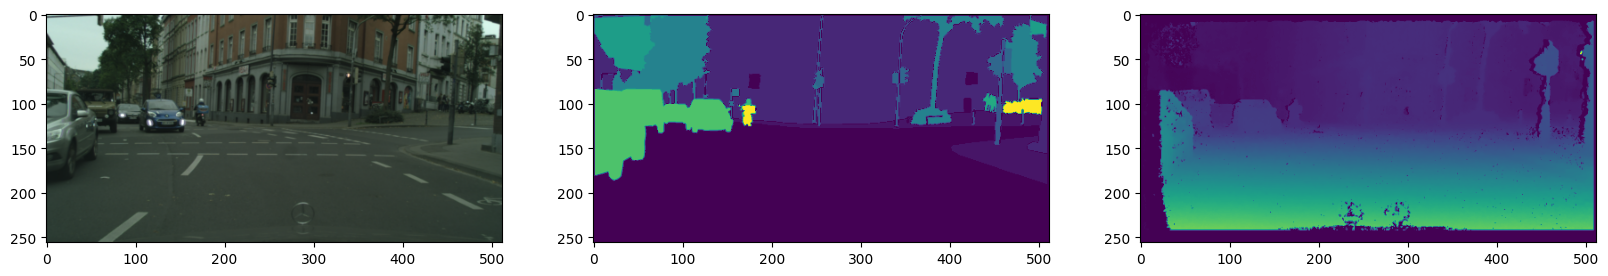

In [5]:
for idx in range(1):
    data, target = train_fine_ds[idx]

    semantic_target = target['semantic']
    depth_target = target['depth']
    
    print(f"data shape: {data.shape}")
    print(f"semantic_target shape: {semantic_target.shape}")
    print(f"depth_target shape: {depth_target.shape}")
    
    num_class = semantic_target.shape[0]
    print(f"Number classes: {num_class}")
    print(f"Classes: {torch.unique(torch.argmax(semantic_target, dim = 0))}")
    
    f, axarr = plt.subplots(1, 3, figsize=(20, 15))
    axarr[0].imshow(data.permute(1, -1, 0).numpy())
    axarr[1].imshow(torch.argmax(semantic_target, dim = 0).unsqueeze(0).permute(1, -1, 0).numpy())
    axarr[2].imshow(depth_target.permute(1, -1, 0).numpy())

In [6]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [7]:
class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [8]:
class Pyramid(nn.Module):
    def __init__(self, n_channels=3):
        super(Pyramid, self).__init__()
        self.n_channels = n_channels

        self.inc = (DoubleConv(n_channels, 32))
        self.down1 = (Down(32, 64)) #64, 128
        self.down2 = (Down(64, 128)) #128, 256
        self.down3 = (Down(128, 256)) #256, 512
        self.down4 = (Down(256, 512)) #512, 1024

        self.toplayer = nn.Sequential(
            nn.Conv2d(512, 64, kernel_size=1, stride=1, padding=0),
            # nn.Upsample(scale_factor=2, mode='bilinear')
        )

        self.latlayer1 = nn.Conv2d(256, 64, kernel_size=1, stride=1, padding=0)
        self.latlayer2 = nn.Conv2d(128, 64, kernel_size=1, stride=1, padding=0)
        self.latlayer3 = nn.Conv2d(64, 64, kernel_size=1, stride=1, padding=0)

        self.smooth1 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.smooth2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.smooth3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        
        # Depth prediction
        self.predict1 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
        self.predict2 = nn.Sequential(
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )

        self.up = nn.Upsample(scale_factor=2, mode='bilinear')

    def _upsample_add(self, x, y):
        _,_,H,W = y.size()
        return F.interpolate(x, size=(H,W), mode='bilinear') + y
        
    def forward(self, x):
        d1 = self.inc(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)

        u5 = self.toplayer(d5)
        
        u4 = self._upsample_add(u5, self.latlayer1(d4))
        u4 = self.smooth1(u4)
        u3 = self._upsample_add(u4, self.latlayer2(d3))
        u3 = self.smooth2(u3)
        u2 = self._upsample_add(u3, self.latlayer3(d2))
        u2 = self.smooth2(u2)

        u1 = self.up(u2)

        return self.predict2(self.predict1(u1))

In [9]:
# class GradLoss(nn.Module):
#     def __init__(self):
#         super(GradLoss, self).__init__()
    
#     # L1 norm
#     def forward(self, grad_fake, grad_real):
#         return torch.mean(torch.abs(grad_real-grad_fake))

In [10]:
# def imgrad(img):
#     img = torch.mean(img, 1, True)
#     # grad x
#     fx = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
#     conv1 = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1, bias=False)
#     weight = torch.from_numpy(fx).float().unsqueeze(0).unsqueeze(0).to(img.device)
#     conv1.weight = nn.Parameter(weight)
#     grad_x = conv1(img)
    
#     # grad y
#     fy = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
#     conv2 = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1, bias=False)
#     weight = torch.from_numpy(fy).float().unsqueeze(0).unsqueeze(0).to(img.device)
#     conv2.weight = nn.Parameter(weight)
#     grad_y = conv2(img)
#     return grad_y, grad_x

# def imgrad_yx(img):
#     N,C,_,_ = img.size()
#     grad_y, grad_x = imgrad(img)
#     return torch.cat((grad_y.view(N,C,-1), grad_x.view(N,C,-1)), dim=1)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 1)

model = Pyramid().to(device)

optimizer = Adam(params = model.parameters(), lr = 0.001)

epochs = 100

# loss_fn = GradLoss()
loss_fn = nn.MSELoss()

In [12]:
for epoch in range(10):
    total_train_loss = 0
    model.train()
    for i, (train_img, train_depth) in tqdm(enumerate(train_fine_dl)):
        train_img, train_depth = train_img.to(device), train_depth['depth'].to(device)
        
        train_depth_fake = model(train_img)
        # train_grad_real, train_grad_fake = imgrad_yx(train_depth), imgrad_yx(train_depth_fake)
        
        train_loss = loss_fn(train_depth_fake, train_depth)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        total_train_loss += train_loss.item()
        
    with torch.no_grad():
        model.eval()
        total_valid_loss = 0
        for i, (valid_img, valid_depth) in tqdm(enumerate(valid_fine_dl)):
            valid_img, valid_depth = valid_img.to(device), valid_depth['depth'].to(device)
            
            valid_depth_fake = model(valid_img)
            # valid_grad_real, valid_grad_fake = imgrad_yx(valid_depth), imgrad_yx(valid_depth_fake)
            
            valid_loss = loss_fn(valid_depth_fake, valid_depth)
            total_valid_loss += valid_loss.item()

    print(f"Epoch: {epoch} - Train Loss: {total_train_loss/len(train_fine_dl)} - Valid Loss: {total_valid_loss/len(valid_fine_dl)}")

93it [00:37,  2.49it/s]
16it [00:06,  2.40it/s]

Epoch: 0 - Train Loss: 0.012647269023281912 - Valid Loss: 0.0050389601674396545



93it [00:29,  3.18it/s]
16it [00:06,  2.54it/s]

Epoch: 1 - Train Loss: 0.0037216312021657984 - Valid Loss: 0.0036148578656138852



93it [00:29,  3.16it/s]
16it [00:06,  2.55it/s]

Epoch: 2 - Train Loss: 0.0029802508877530215 - Valid Loss: 0.0030875889788148925



93it [00:29,  3.13it/s]
16it [00:06,  2.55it/s]

Epoch: 3 - Train Loss: 0.002616204676889284 - Valid Loss: 0.002803019102429971



93it [00:29,  3.18it/s]
16it [00:06,  2.50it/s]

Epoch: 4 - Train Loss: 0.0024499794923930718 - Valid Loss: 0.0028785328613594174



93it [00:28,  3.27it/s]
16it [00:06,  2.63it/s]

Epoch: 5 - Train Loss: 0.002297706650419822 - Valid Loss: 0.002354328564251773



93it [00:29,  3.18it/s]
16it [00:06,  2.49it/s]

Epoch: 6 - Train Loss: 0.002158315079937619 - Valid Loss: 0.0024743390240473673



93it [00:29,  3.19it/s]
16it [00:06,  2.50it/s]

Epoch: 7 - Train Loss: 0.002065352077836231 - Valid Loss: 0.002205551434599329



93it [00:29,  3.14it/s]
16it [00:06,  2.55it/s]

Epoch: 8 - Train Loss: 0.001977202583915524 - Valid Loss: 0.0021631115887430497



93it [00:30,  3.09it/s]
16it [00:06,  2.50it/s]

Epoch: 9 - Train Loss: 0.0019349797042988001 - Valid Loss: 0.002161980912205763


In [13]:
with torch.no_grad():
    model.eval()
    total_test_loss = 0
    for i, (test_img, test_depth) in tqdm(enumerate(test_fine_dl)):
        test_img, test_depth = test_img.to(device), test_depth['depth'].to(device)
        
        test_depth_fake = model(test_img)
        test_grad_real, test_grad_fake = imgrad_yx(test_depth), imgrad_yx(test_depth_fake)
        
        test_loss = loss_fn(test_grad_real, test_grad_fake)
        total_test_loss += test_loss.item()
print(f"Test Loss: {total_test_loss/len(test_fine_dl)}")

48it [00:13,  3.50it/s]

Test Loss: 0.014019665114271143


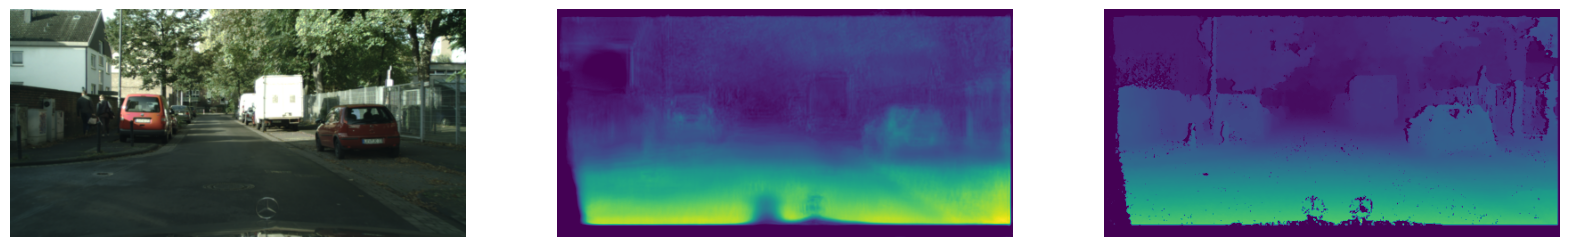

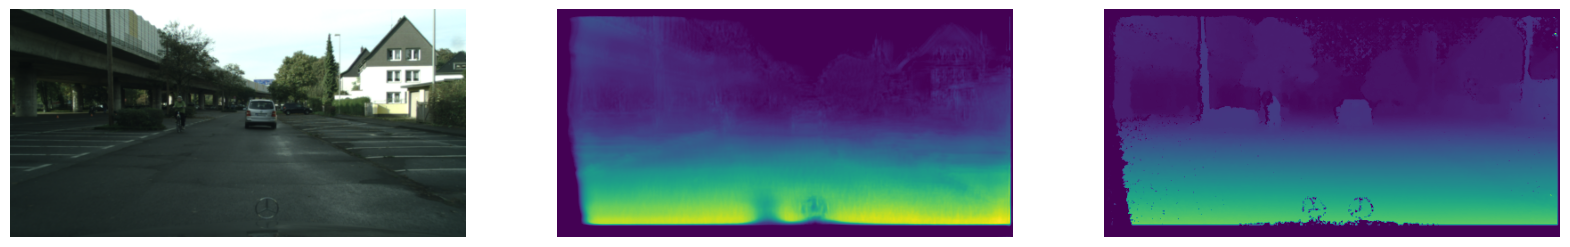

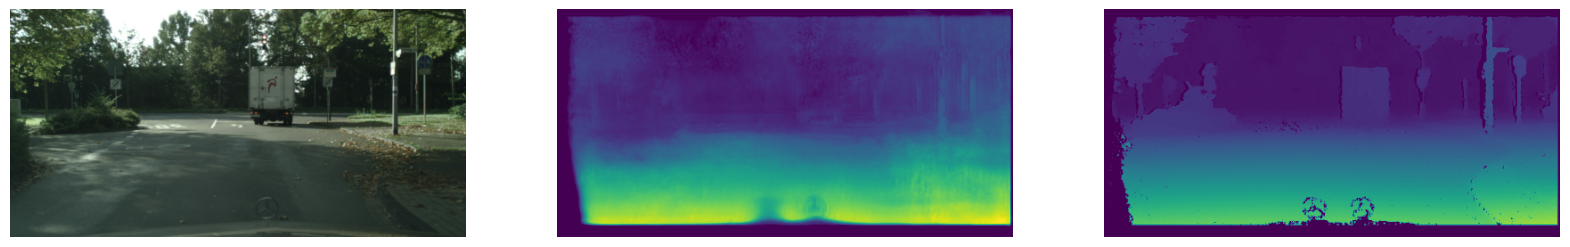

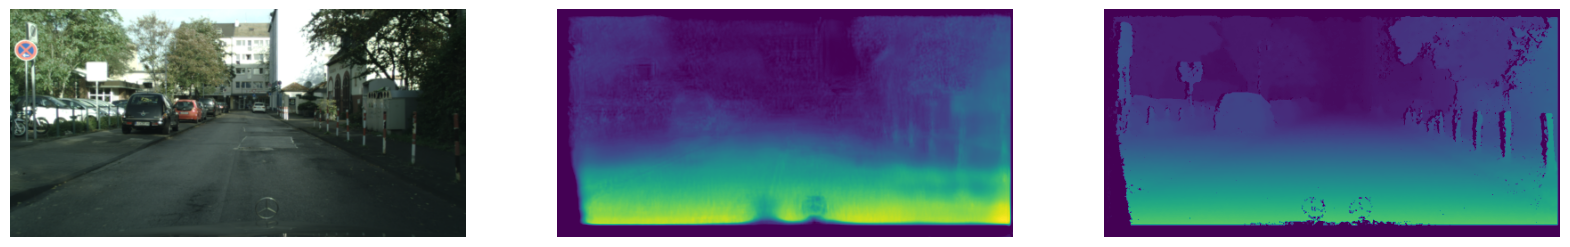

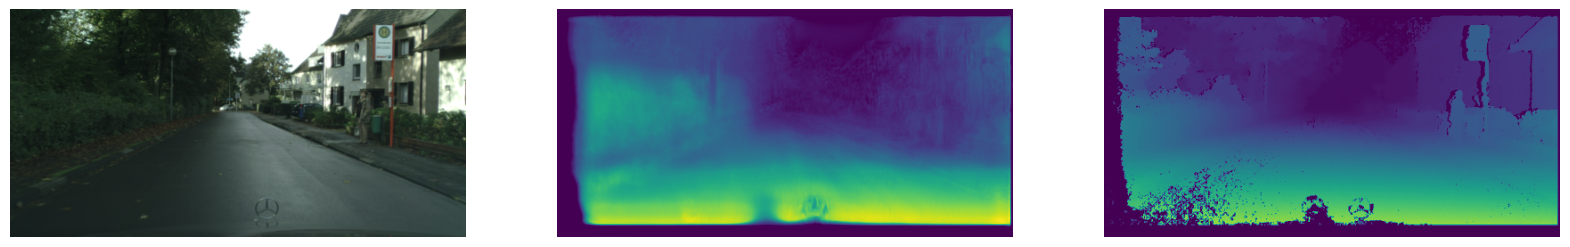

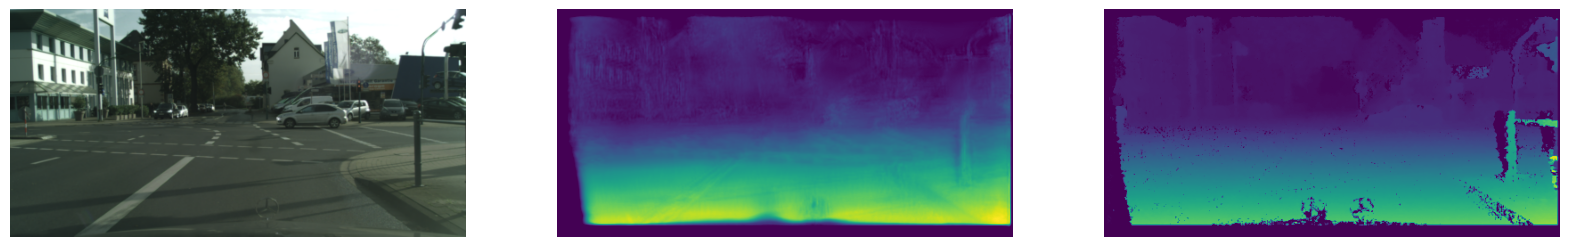

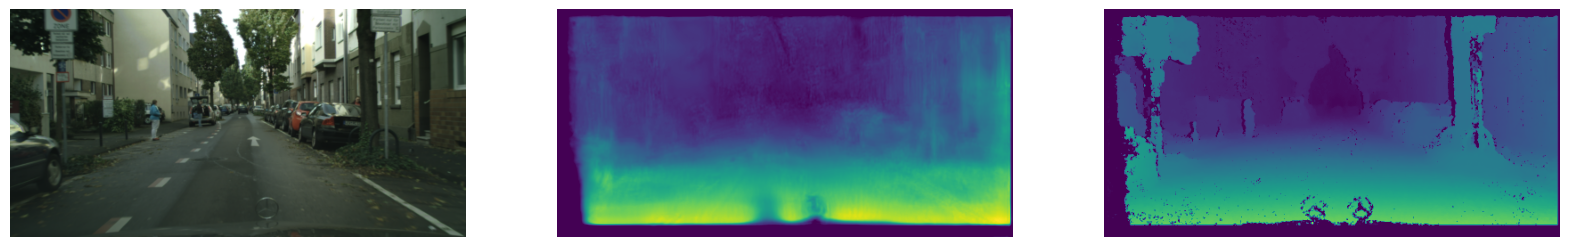

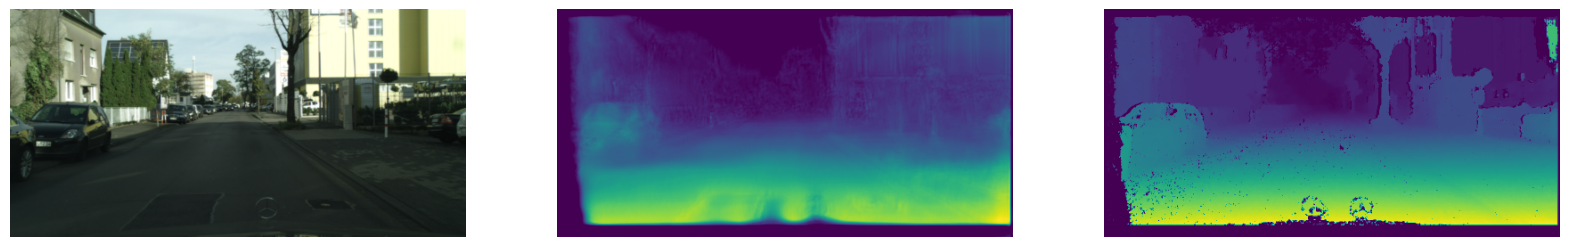

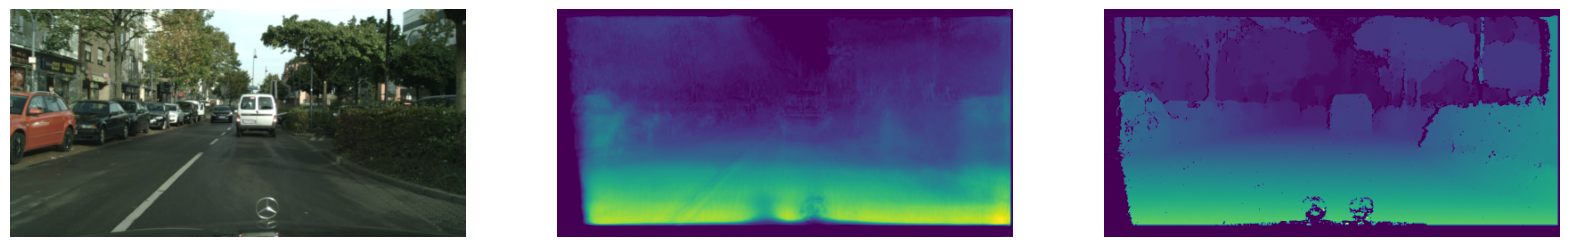

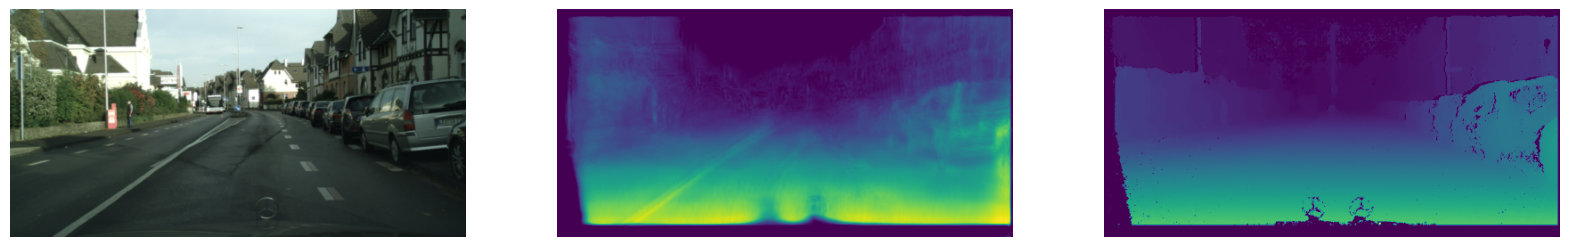

In [14]:
model.eval()

with torch.no_grad():
    for test_case_idx in range(10):
        test_img, test_depth = test_fine_ds[test_case_idx]
        test_img = test_img.unsqueeze(dim=0).to(device)
        test_depth = test_depth['depth']

        test_depth_fake = model(test_img)     
        f, axarr = plt.subplots(1, 3, figsize = (20,15))
        axarr[0].imshow(test_img[0].cpu().permute(1, -1, 0).numpy())
        axarr[0].axis('off')
        axarr[1].imshow(test_depth_fake[0].permute(1, -1, 0).cpu().numpy())
        axarr[1].axis('off')
        axarr[2].imshow(test_depth.permute(1, -1, 0).cpu().numpy())
        axarr[2].axis('off')